# 0. 라이브러리 로딩

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('ggplot')
#ggplot is R based visualisation package that provides better graphics with higher level of abstraction

In [5]:
# 데이터셋 다운로드 및 로드
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
diabetes_data = pd.read_csv(url, names=column_names)

# 처음 5개 데이터만 출력
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 1. 데이터셋 업샘플링

In [3]:
# 데이터 업샘플링 위해서
!pip install imbalanced-learn

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']
print('원래 클래스 분포:\n', y.value_counts())

# 정상데이터 비율을 95%로 업샘플링해서 이상치 탐지 태스크를 수행할 수 있게 함
ratio = 0.95
curr_ratio = y.value_counts(normalize=True)[0]

# 업샘플링 해야 하는 비율 계산
sampling_strategy_value = (ratio * (1 - curr_ratio)) / (curr_ratio * (1 - ratio))
sampling_strategy = {0: int(y.value_counts()[0] * (1 + sampling_strategy_value))}

# RandomOverSampler 객체 생성
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# 오버샘플링 적용
X_resampled, y_resampled = ros.fit_resample(X, y)
y_resampled_series = pd.Series(y_resampled)

# X_resampled을 pandas DataFrame으로 변환
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

# BMI와 DiabetesPedigreeFunction 열에 노이즈 추가
noise_bmi = np.random.normal(loc=0, scale=0.01, size=X_resampled.shape[0])
noise_dpf = np.random.normal(loc=0, scale=0.01, size=X_resampled.shape[0])

X_resampled_df['BMI'] += noise_bmi
X_resampled_df['DiabetesPedigreeFunction'] += noise_dpf

# 결과 출력
print("업샘플링 후 데이터 크기:", X_resampled_df.shape)
print("업샘플링 후 클래스 분포:\n", y_resampled_series.value_counts())

원래 클래스 분포:
 Outcome
0    500
1    268
Name: count, dtype: int64
업샘플링 후 데이터 크기: (5859, 8)
업샘플링 후 클래스 분포:
 Outcome
0    5591
1     268
Name: count, dtype: int64


### 데이터 Scaling

In [7]:
#데이터 표준화
scaler = StandardScaler()
scaler.fit(X_resampled_df)
df_scaled = scaler.transform(X_resampled_df)
df_scaled = pd.DataFrame(df_scaled)
x_df_scaled = df_scaled.copy()
df_scaled['target'] = y_resampled_series

# 2. Feature 중요도 분석

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 2-1. 상관계수

Pregnancies                 0.110379
Glucose                     0.240449
BloodPressure               0.028007
SkinThickness               0.032797
Insulin                     0.064428
BMI                         0.128893
DiabetesPedigreeFunction    0.083032
Age                         0.106995
dtype: float64


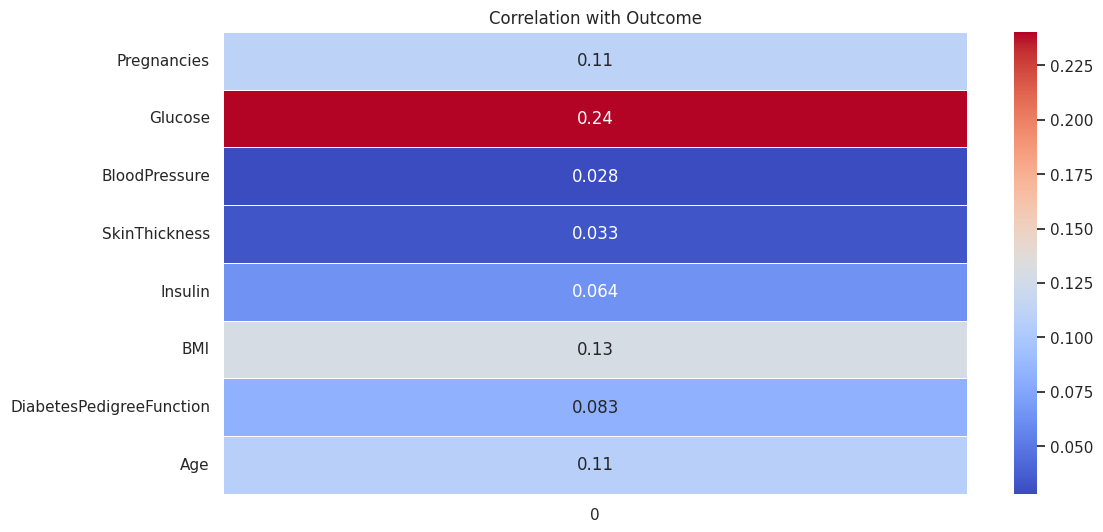

In [9]:
#각 특성과 라벨 간의 상관계수 계산
correlation_matrix = X_resampled_df.corrwith(y_resampled_series)
print(correlation_matrix)

#시각화
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation with Outcome')
plt.show()

## 2-2. 로지스틱 회귀

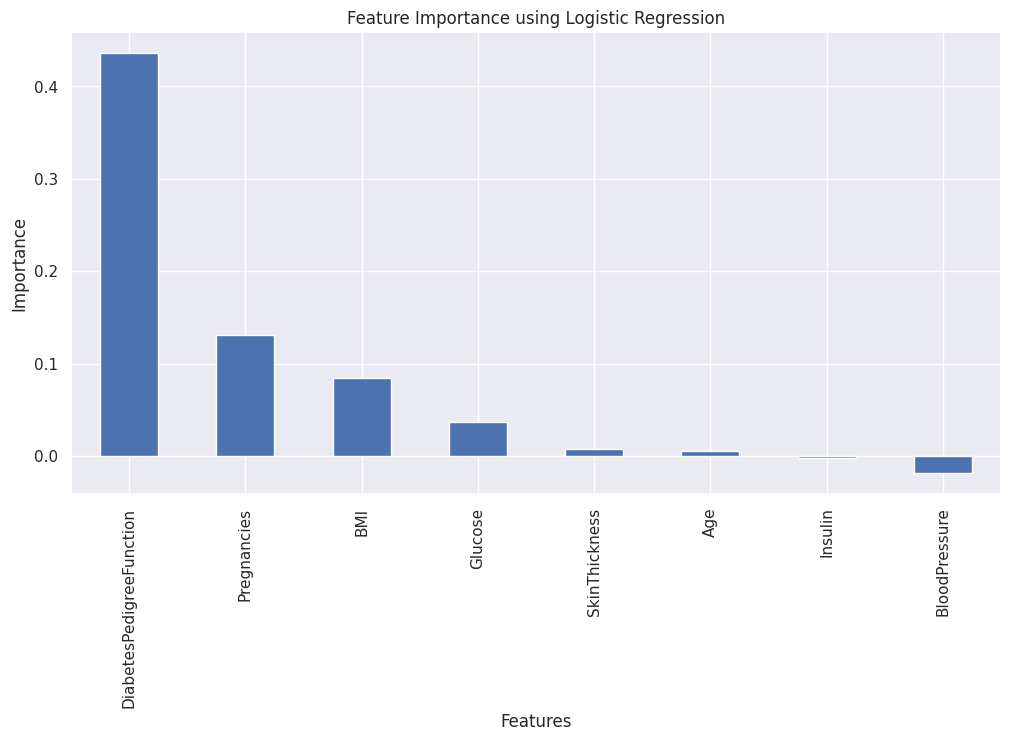

In [10]:
#max_iter으로 모델의 최대 반복 횟수를 설정
log_reg = LogisticRegression(max_iter=10000)

#로지스틱 회귀 모델 훈련
log_reg.fit(X_resampled, y_resampled)

#회귀 계수를 통해 특성 중요도 계산
importance = log_reg.coef_[0] #훈련된 모델의 계수 가져옴
feature_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)
#각 계수를 특성 이름과 매칭 시켜 Series로 변환

#특성 중요도 시각화
plt.figure(figsize=(12, 6)) #그림의 크기 설정
feature_importance.plot(kind='bar') #bar차트로 특성 중요도 시각화
plt.title('Feature Importance using Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## 2-3. 랜덤 포레스트

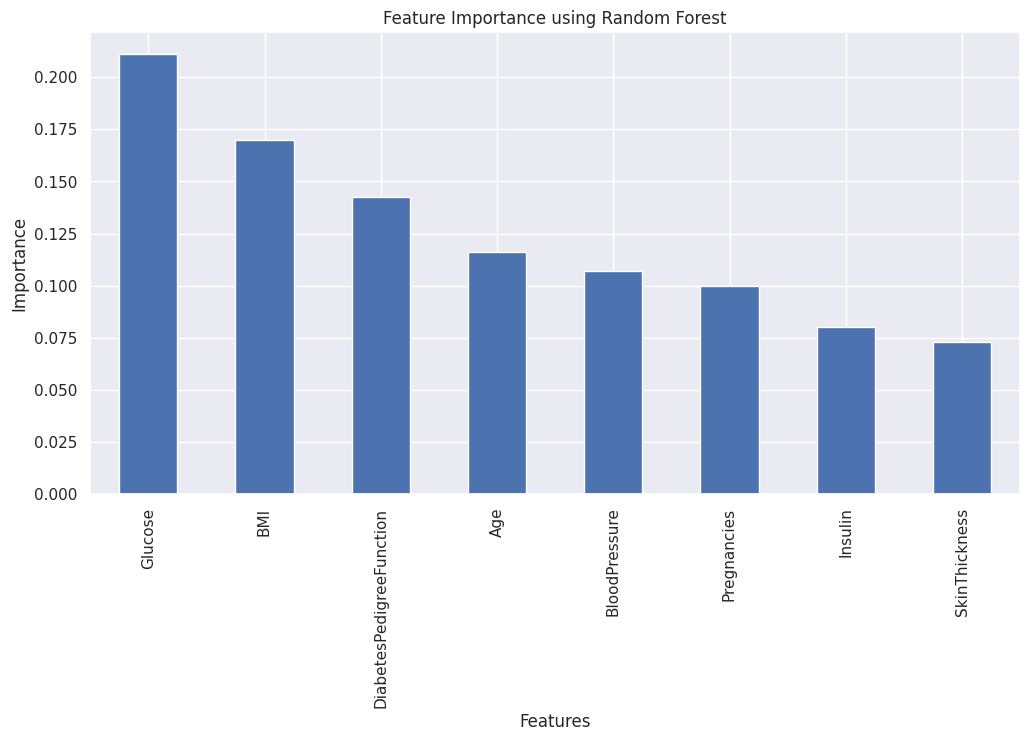

In [11]:
#랜덤 포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42) #재현성을 위해 random_state = 42로 설정

#랜덤 포레스트 모델 훈련
rf_model.fit(X_resampled, y_resampled)

#특성 중요도 계산
importance = rf_model.feature_importances_

#특성 중요도를 Series로 변환하고 정렬
feature_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)

#특성 중요도 시각화
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance using Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# 3. 이상 탐지 수행

코드를 수행할 때마다 결과가 약간씩 달라져서 동영상과 차이가 있을 수 있습니다.

In [12]:
#trian, test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(X_resampled_df, y_resampled_series, test_size=0.2, random_state=42)

In [13]:
# y_train 클래스 분포 확인
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution in y_train:")
print(class_distribution)
print(209/4478)

Class distribution in y_train:
{0: 4478, 1: 209}
0.0466726217061188


In [14]:
# y_test 클래스 분포 확인
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution in y_test:")
print(class_distribution)
print(59/1113)

Class distribution in y_test:
{0: 1113, 1: 59}
0.053009883198562445


## 3-1. Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

# Glucose 및 DiabetesPedigreeFunction 특성만 선택
X_train_subset = X_train[['Glucose', 'DiabetesPedigreeFunction']]
X_test_subset = X_test[['Glucose', 'DiabetesPedigreeFunction']]

# Isolation Forest 모델 훈련
iso_forest = IsolationForest(contamination=0.095, random_state=42)
iso_forest.fit(X_train_subset)

# 이상치 예측
y_pred_test = iso_forest.predict(X_test_subset)

In [16]:
y_true_binary = (y_test == 1)
y_pred_binary = (y_pred_test == -1)

# 혼동 행렬 생성
cm = confusion_matrix(y_true_binary, y_pred_binary)

print("Confusion Matrix:")
print(cm)

# 성능 지표 계산
accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[1000  113]
 [  35   24]]
Accuracy: 0.8737201365187713
Precision: 0.17518248175182483
Recall: 0.4067796610169492
F1 Score: 0.2448979591836735


## 3-2. Oneclass SVM - Random search

In [17]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# 특성 선택
X_train_subset = X_train[['Glucose', 'DiabetesPedigreeFunction']]
X_test_subset = X_test[['Glucose', 'DiabetesPedigreeFunction']]

# One-Class SVM 모델 정의
oc_svm = OneClassSVM()

# 랜덤 서치를 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'nu': [0.01, 0.05, 0.1, 0.2, 0.5],  # nu의 후보값들
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # 커널 종류
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]  # gamma의 후보값들
}

# 성능 평가를 위한 사용자 정의 스코어 함수 정의
def custom_scorer(y_true, y_pred):
    # 이진 분류에서는 이상치를 양성 클래스(1)로 설정
    y_true_binary = (y_true == 1)
    y_pred_binary = (y_pred == -1)

    return f1_score(y_true_binary, y_pred_binary)

scorer = make_scorer(custom_scorer, greater_is_better=True)

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(oc_svm,
                                   param_distributions=param_dist,
                                   n_iter=50, scoring=scorer,
                                   refit=True, cv=5, random_state=42)

# 랜덤 서치 모델 훈련
random_search.fit(X_train_subset, y_train)

# 최적의 파라미터 출력
print("Best Parameters: ", random_search.best_params_)

# 최적의 모델로 테스트 데이터에 대한 예측 수행
best_oc_svm = random_search.best_estimator_
y_pred_test = best_oc_svm.predict(X_test_subset)

Best Parameters:  {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'auto'}


In [18]:
y_true_binary = (y_test == 1)
y_pred_binary = (y_pred_test == -1)

# 혼동 행렬 생성
cm = confusion_matrix(y_true_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# 성능 지표 계산
accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[1078   35]
 [  36   23]]
Accuracy: 0.939419795221843
Precision: 0.39655172413793105
Recall: 0.3898305084745763
F1 Score: 0.39316239316239315


## 3-3. Random Forest - Random Search

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Glucose,DiabetesPedigreeFunction 특성 선택
X_train_RFC = X_train[['Glucose', 'DiabetesPedigreeFunction']]
X_test_RFC = X_test[['Glucose', 'DiabetesPedigreeFunction']]

# 랜덤 포레스트 모델 정의
rf_model = RandomForestClassifier(random_state=42)

# 랜덤 서치를 위한 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_dist,
                                   n_iter=100, scoring='accuracy',
                                   cv=5, random_state=42,
                                   n_jobs=-1, verbose=2)

# 랜덤 서치 모델 훈련
random_search.fit(X_train_RFC, y_train)

# 최적의 파라미터 출력
print("Best Parameters: ", random_search.best_params_)

# 최적의 모델로 테스트 데이터에 대한 예측 수행
best_rf_model = random_search.best_estimator_
y_pred_test_RFC = best_rf_model.predict(X_test_RFC)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [20]:
# 혼동 행렬 생성
cm_RFC = confusion_matrix(y_test, y_pred_test_RFC)
print("Confusion Matrix:")
print(cm_RFC)

# 이진 분류의 성능 지표 계산
accuracy_RFC = accuracy_score(y_test, y_pred_test_RFC)
precision_RFC = precision_score(y_test, y_pred_test_RFC, average='macro')
recall_RFC = recall_score(y_test, y_pred_test_RFC, average='macro')
f1_RFC = f1_score(y_test, y_pred_test_RFC, average='macro')

print("Accuracy:", accuracy_RFC)
print("Precision:", precision_RFC)
print("Recall:", recall_RFC)
print("F1 Score:", f1_RFC)

Confusion Matrix:
[[1111    2]
 [  38   21]]
Accuracy: 0.9658703071672355
Precision: 0.9399856207666402
Recall: 0.6770676290983294
F1 Score: 0.7472558279959458


## 3-4. Elliptic Envelope (가우시안)

In [21]:
#trian, test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(x_df_scaled, y_resampled_series, test_size=0.2, random_state=42)

In [22]:
from sklearn.covariance import EllipticEnvelope

# Glucose feature만 학습에 사용
X_train = X_train[[1]]
X_test = X_test[[1]]

# Elliptic Envelope 모델 초기화
elliptic_env = EllipticEnvelope(contamination=0.04)  # contamination은 이상치 비율

# Elliptic Envelope 모델을 학습
elliptic_env.fit(X_train)

# 예측 (1: 정상치, -1: 이상치)
predictions = elliptic_env.predict(X_test)

# 예측 결과를 0 (정상치)와 1 (이상치)로 변환
predictions = np.where(predictions == 1, 0, 1)

# 예측 결과를 새로운 열로 추가
elliptic_X_test = X_test.copy()
elliptic_X_test['anomaly'] = predictions

In [23]:
# 실제 값과 예측 값
actual = y_test  # 실제 레이블
predicted = elliptic_X_test['anomaly']  # 예측 레이블

# Confusion Matrix 생성
cm = confusion_matrix(actual, predicted)

# Confusion Matrix 출력
print("Confusion Matrix:")
print(cm)

# 성능 지표 계산
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[1070   43]
 [  43   16]]
Accuracy: 0.9266211604095563
Precision: 0.2711864406779661
Recall: 0.2711864406779661
F1 Score: 0.2711864406779661


## 3-5. Autoencoder

In [24]:
#trian, test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(x_df_scaled, y_resampled_series, test_size=0.2, random_state=42)

### train시에 정상 데이터만 사용

In [25]:
# 학습용 데이터에서 정상 데이터(0)만 선택
X_train_normal = X_train[y_train == 0]

# 결과 출력
print("학습용 정상 데이터 크기:", X_train_normal.shape)
print("학습용 정상 데이터 클래스 분포:\n", y_train.value_counts())

학습용 정상 데이터 크기: (4478, 8)
학습용 정상 데이터 클래스 분포:
 Outcome
0    4478
1     209
Name: count, dtype: int64


In [26]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 모델 설계
input_dim = X_train.shape[1]  # 입력 차원 (feature 수)
encoding_dim = 15  # 압축할 차원

# 모델 구조
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 15)                135       
                                                                 
 dense_1 (Dense)             (None, 7)                 112       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 8)                 64        
                                                                 
Total params: 367 (1.43 KB)
Trainable params: 367 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# 모델 학습
nb_epoch = 500
batch_size = 64


autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

history = autoencoder.fit(X_train_normal, X_train_normal, # train시에 정상 데이터만으로 학습
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),     # validation시에는 정상 + 비정상 데이터로 검증
                    verbose=1).history
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="/kaggle/working/autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

Epoch 1/500
70/70 [==============================] - 4s 13ms/step - loss: 1.0054 - accuracy: 0.1356 - val_loss: 0.9747 - val_accuracy: 0.1553
Epoch 2/500
70/70 [==============================] - 0s 7ms/step - loss: 0.8837 - accuracy: 0.2448 - val_loss: 0.8621 - val_accuracy: 0.2705
Epoch 3/500
70/70 [==============================] - 0s 7ms/step - loss: 0.7642 - accuracy: 0.3158 - val_loss: 0.7488 - val_accuracy: 0.2995
Epoch 4/500
70/70 [==============================] - 0s 7ms/step - loss: 0.6743 - accuracy: 0.3310 - val_loss: 0.6689 - val_accuracy: 0.3498
Epoch 5/500
70/70 [==============================] - 0s 6ms/step - loss: 0.5994 - accuracy: 0.3631 - val_loss: 0.5926 - val_accuracy: 0.3660
Epoch 6/500
70/70 [==============================] - 0s 6ms/step - loss: 0.5308 - accuracy: 0.3535 - val_loss: 0.5322 - val_accuracy: 0.3456
Epoch 7/500
70/70 [==============================] - 1s 8ms/step - loss: 0.4829 - accuracy: 0.3446 - val_loss: 0.4937 - val_accuracy: 0.3532
Epoch 8/500


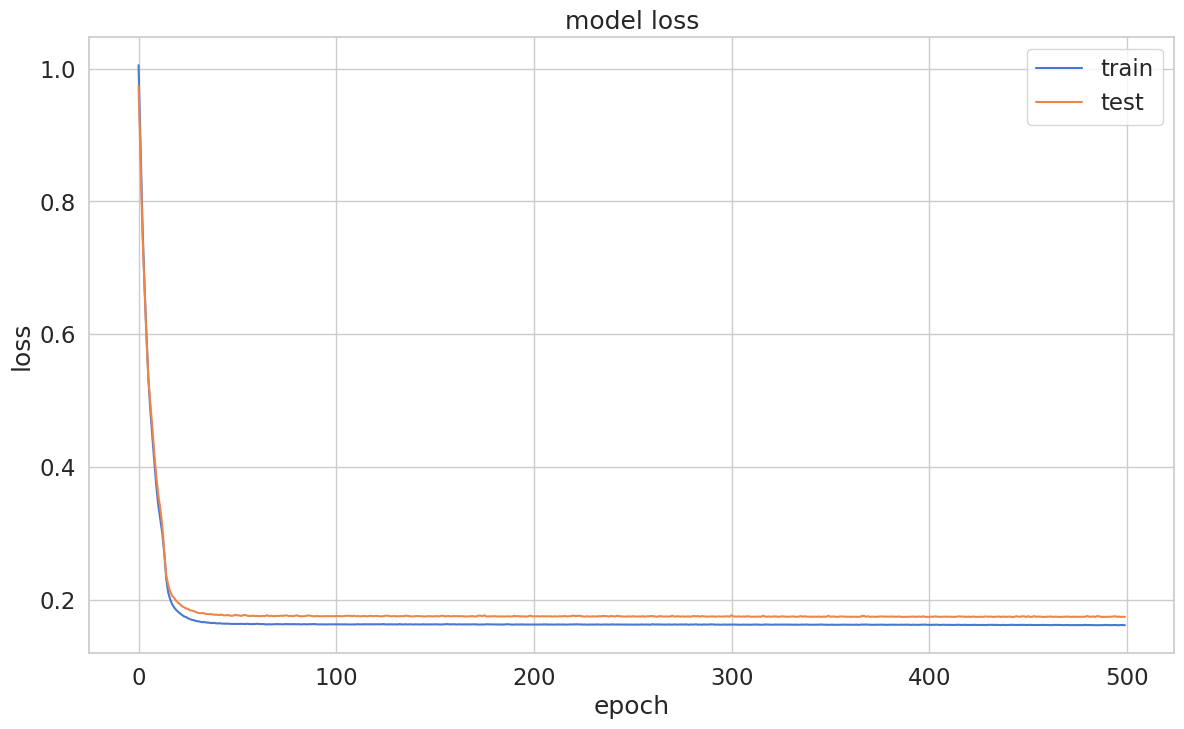

In [29]:
# model loss 시각화
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# test data로 reconstruction error 계산
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

# 재구성 오류 기반 이상치 여부 예측
threshold = 0.18            # 이상치로 판단할 기준
predicted_anomalies = (reconstruction_errors > threshold).astype(int)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test
                               , predicted_anomalies)
accuracy = accuracy_score(y_test, predicted_anomalies)
precision = precision_score(y_test, predicted_anomalies)
recall = recall_score(y_test, predicted_anomalies)
f1 = f1_score(y_test, predicted_anomalies)

# 성능 지표 출력
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

37/37 [==============================] - 0s 2ms/step
Confusion Matrix:
[[809 304]
 [ 26  33]]
Accuracy: 0.7184300341296929
Precision: 0.09792284866468842
Recall: 0.559322033898305
F1 Score: 0.16666666666666663


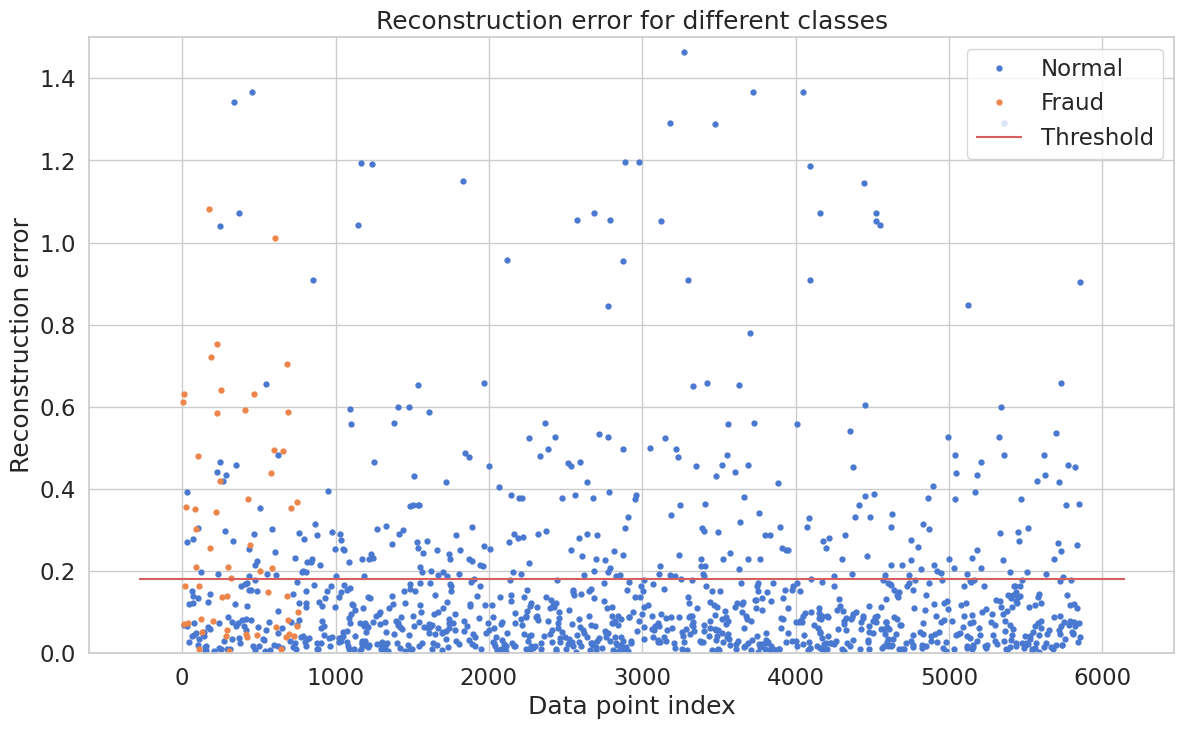

In [31]:
# error_df 생성
error_df = pd.DataFrame({'reconstruction_error': reconstruction_errors,
                         'true_class': y_test})

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

# reconstruction error 시각화
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.set_ylim(0, 1.5)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();